# Chapter 3
#### From Stephen Klosterman's book DATA SCIENCE PROJECTS WITH PYTHON (2019).

<h3>Goals:</h3>
<ul>
    <li>Write list comprehensions in Python</li>
    <li>Describe the workings of logistic regression</li>
    <li>Formulate the sigmoid and logit versions of logistic regression</li>
    <li>Utilize univariate feature selection to find important features</li>
    <li>Customize plots with the Matplotlib API</li>
    <li>Characterize the linear decision boundary of a logistic regression</li>
</ul>

In [1]:
import sys
import numpy as np
import pandas as pd
import sklearn

sklearn.__version__

'0.22.1'

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns # fancy plotting package

%matplotlib inline

mpl.rcParams['figure.dpi'] = 400 # high resolution

#### Load data

In [3]:
df = pd.read_csv("Data/Chapter_1_cleaned_data_OLD.csv")

## Examining the Relationships Between Features and the Response

In [4]:
features_response = df.columns.tolist()
features_response

['ID',
 'LIMIT_BAL',
 'SEX',
 'EDUCATION',
 'MARRIAGE',
 'AGE',
 'PAY_1',
 'PAY_2',
 'PAY_3',
 'PAY_4',
 'PAY_5',
 'PAY_6',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6',
 'default payment next month',
 'EDUCATION_CAT',
 'graduate school',
 'high school',
 'none',
 'others',
 'university']

In [5]:
features_response[:5]

['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE']

In [6]:
features_response[-5:]

['graduate school', 'high school', 'none', 'others', 'university']

<p> We are not to use the gender variable due to ethical concerns, and we learn that <code>PAY_2</code>, <code>PAY_3</code>, all the way to <code>PAY_6</code> are incorrect and should be ignored. Also, we are not using the one-hot encoding of the <code>EDUCATION</code> variable, but we will use the variable directly. Finally, we do not need the <code>ID</code> feature for our calculations.</p>

In [7]:
items_to_remove = ['ID', 'SEX', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
                   'EDUCATION_CAT', 'graduate school', 'high school', 'none',
                   'others', 'university']

<p>Use <strong>list comprehensions</strong> to remove the names in <code>items_to_remove</code> from the current list contained in <code>features_response</code>.</p>

<p>"A list comprehension consists of brackets containing an expression followed by a <strong>for</strong> clause, then zero or more for or if clauses."</p>

In [8]:
features_response = [item for item in features_response if item not in items_to_remove]
features_response

['LIMIT_BAL',
 'EDUCATION',
 'MARRIAGE',
 'AGE',
 'PAY_1',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6',
 'default payment next month']

### Pearson Correlation

<p>Underlying a correlation plot is a <strong>correlation matrix</strong>, which we must calculate first: We select our columns of features and response values using the <code>feature_response</code> list we just created and call the <code>.corr()</code> method on these columns.</p>

<p>Note that the type of correlation available to us in Pandas is <strong>linear correlation</strong>, also known as <strong>Pearson correlation</strong>, which is used to measure the strength and direction of the linear relationship between two variables as positive or negative magnitudes.</p>

In [9]:
corr = df[features_response].corr()
corr.iloc[0:5, 0:5]

,LIMIT_BAL,EDUCATION,MARRIAGE,AGE,PAY_1
LIMIT_BAL,1.000000,-0.232688,-0.111873,0.149157,-0.273396
EDUCATION,-0.232688,1.000000,-0.137097,0.179035,0.112653
MARRIAGE,-0.111873,-0.137097,1.000000,-0.412828,0.019759
AGE,0.149157,0.179035,-0.412828,1.000000,-0.044277
PAY_1,-0.273396,0.112653,0.019759,-0.044277,1.000000


<p>Notice that the row and column names are the same. For each pair of variables there is a number called the <strong>correlation</strong>. This number is always between -1 and 1.</p>

#### Heatmap of the correlation matrix with Seaborn

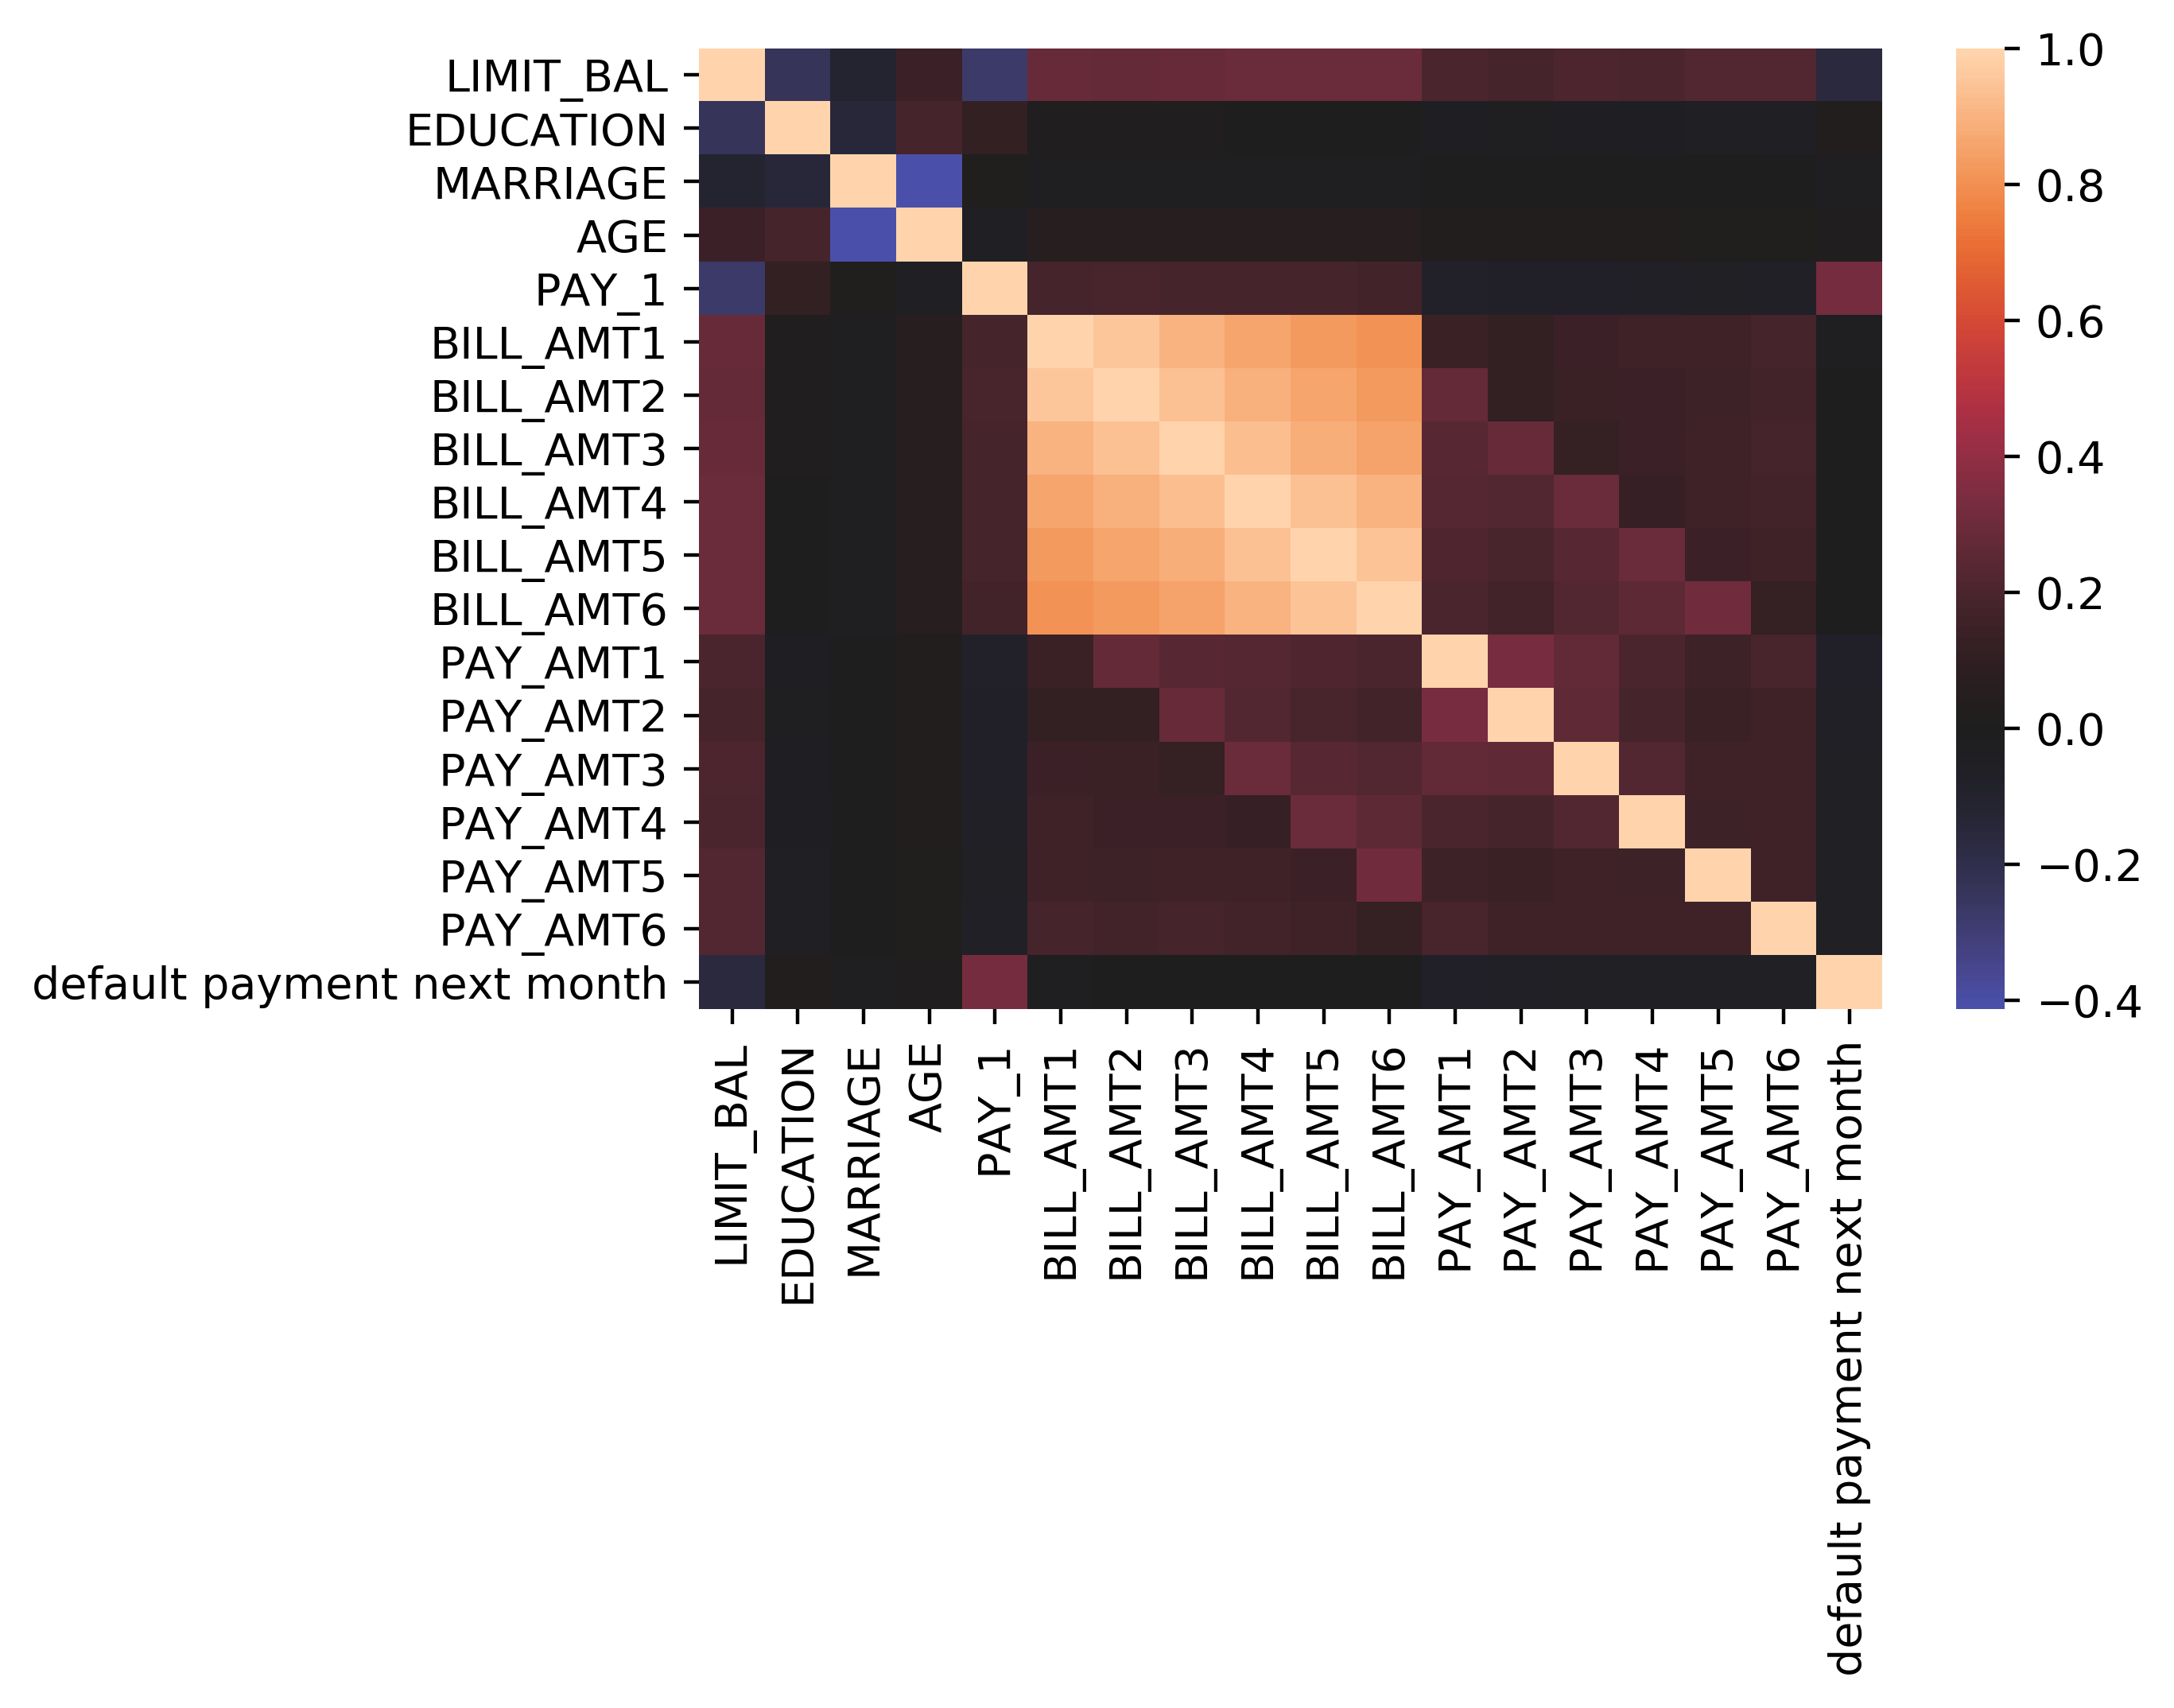

In [10]:
mpl.rcParams['figure.dpi'] = 400
sns.heatmap(corr,
           xticklabels = corr.columns.values,
           yticklabels = corr.columns.values,
           center = 0)

#### Note that technically speaking, among other restrictions, Pearson correlation is only valid for CONTINUOUS DATA. However, Pearson correlation can still accomplish the purpose of giving a quick idea of the potential usefulness of features.

<p>In data science in general, you will find that certain widely used techniques may be applied to data that violates their formal statistical assumptions. It is important to be aware of the formal assumptions underlying methods.</p>

#### Note also that, as its name suggests, inear correlation only picks up on linear relationships.

## Exercise 11: F-test and Univariate Feature Selection

<p>The <strong>ANOVA F-Test</strong>, available in scikit-learn as <strong>f_classif</strong>. ANOVA stands for "analysis of variance".</p>


<p>In the context of the F-test, the <strong>p-value</strong> answers the question: "For the samples in the positive class, how likely is it that the average value of this feature is the same as that of the samples in the negative class?"</p>

<p>If a feature has very different average values between the positive and negative classes, it will:</p>
<ul>
    <li>Be very unlikely that those average values are the same (<strong>low p-value</strong>)</li>
    <li>Probably be a good feature in our model because it will help us discriminate between positive and negative classes</li>
</ul>

<p><strong>Univariate Feature Selection</strong>: the practice of testing features one by one against the response variable, to see which ones have predictive power.</strong>

#### Separate out the features and response as NumPy arrrays.

In [11]:
X = df[features_response].iloc[:,:-1].values
y = df[features_response].iloc[:,-1].values
print(X.shape, y.shape)

(26664, 17) (26664,)


#### Import the <code>f_classif</code> function and feed in the features and response

In [12]:
from sklearn.feature_selection import f_classif

[f_stat, f_p_value] = f_classif(X, y)

#### Let's create a new DataFrame by using a dictionary with key:value pairs of column names and the data to be contained in each column.

In [13]:
f_test_df = pd.DataFrame({'Feature':features_response[:-1],
                          'F statistic':f_stat,
                          'p value':f_p_value})
f_test_df.sort_values('p value')

,Feature,F statistic,p value
4,PAY_1,3156.672300,0.000000e+00
0,LIMIT_BAL,651.324071,5.838366e-142
11,PAY_AMT1,140.612679,2.358354e-32
12,PAY_AMT2,101.408321,8.256124e-24
13,PAY_AMT3,90.023873,2.542641e-21
15,PAY_AMT5,85.843295,2.090120e-20
16,PAY_AMT6,80.420784,3.219565e-19
14,PAY_AMT4,79.640021,4.774112e-19
1,EDUCATION,32.637768,1.122175e-08
2,MARRIAGE,18.078027,2.127555e-05


#### As can be seen in both the heatmap, the most useful features are PAY_1 and LIMIT_BAL, as they correlate more strongly with our target feature. They have the smallest p-values, and these will help predict which class a sample belongs to.

#### Why? Because a smaller p-value indicates the average values of these features between the positive and negative classes are significantly different.

#### Now let's select the top 20% features according to the F-test.

In [14]:
from sklearn.feature_selection import SelectPercentile

selector = SelectPercentile(f_classif, percentile=20)
selector.fit(X, y)

# gets names of features, not just values
best_feature_ix = selector.get_support() 

best_feature_ix

array([ True, False, False, False,  True, False, False, False, False,
       False, False,  True,  True, False, False, False, False])

In [15]:
features = features_response[:-1]

best_features = [features[counter] for counter in range(len(features))
                 if best_feature_ix[counter]]

best_features

['LIMIT_BAL', 'PAY_1', 'PAY_AMT1', 'PAY_AMT2']

<p>When we use an <strong>F-test</strong> to look at the difference in means between just two groups, the test we are performing actually reduces to a <strong>t-test</strong>. An <strong>F-test</strong> is extensible to three or more groups and so is useful for multiclass classification. A <strongt>test</strong> just compares the means between two groups of samples, to see if the difference in thse means is <em>statistically significant</em>.</p>

<h3>Caveats in the use of the F-test</h3>

<p>Going back to the concept of formal statistical assumptions, the data should be <em>normally distributed</em>. We have not checked this.</p>

<p>Many methods that assume a normal distribution are regularly used with non-normal data, often with acceptable results. And the multiple comparison correction is more of a concern when <strong>p-values</strong> are the ultimate quantity of interest: when making statistical inferences. But here, <strong>p-values</strong> are just a means to the end of ranking the features list.</p>

# Exercise 12: Visualizing the Relationship Between Features and Response

In [16]:
overall_default_rate = df['default payment next month'].mean()
overall_default_rate

0.2217971797179718

### PAY_1

In [17]:
group_by_pay_mean_y = df.groupby('PAY_1').agg({'default payment next month':np.mean})
group_by_pay_mean_y

,default payment next month
PAY_1,
-2,0.131664
-1,0.170002
0,0.128295
1,0.336400
2,0.694701
3,0.773973
4,0.682540
5,0.434783
6,0.545455


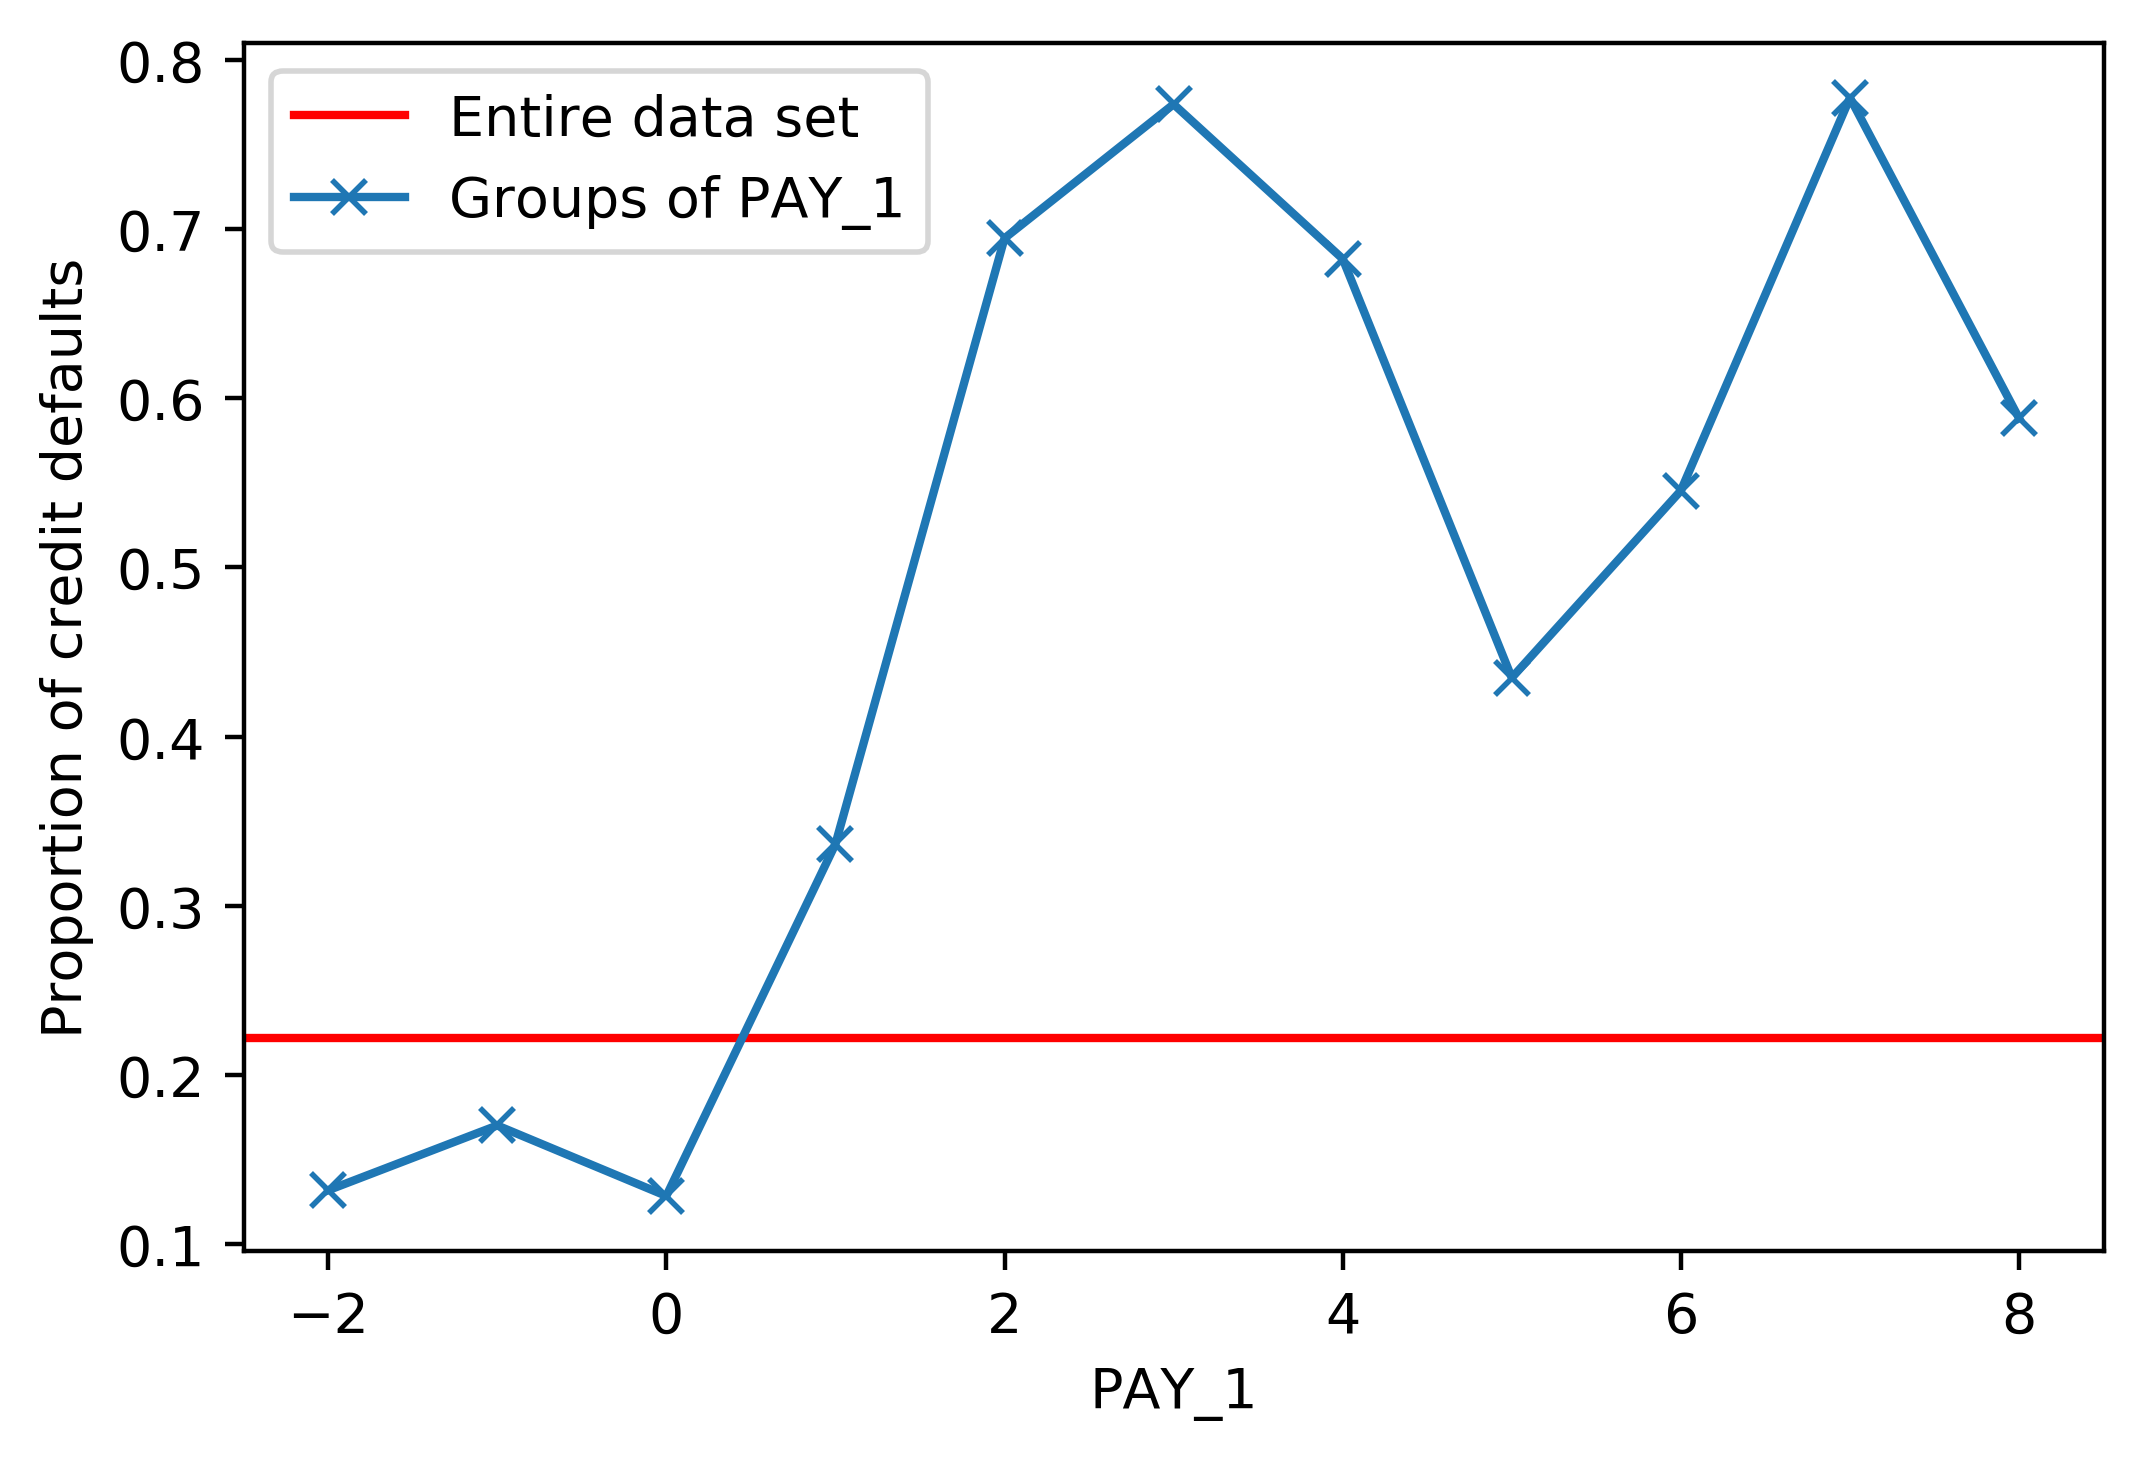

In [18]:
axes = plt.axes()

# Overall default rate as a horizontal red line
axes.axhline(overall_default_rate, color='red')

# plot of the default rate within each group of PAY_1 values
group_by_pay_mean_y.plot(marker='x', legend=False, ax=axes)

axes.set_ylabel('Proportion of credit defaults')
axes.legend(['Entire data set', 'Groups of PAY_1'])

<p>Those who defaulted before, are in fact more likely to default again. The default rate of accounts in good standing is well below the overall default rate, which we know from before is about 22%. However, at least 30% of the accounts that were in default last month will be in default again next month, according to the above plot.</p>

### LIMIT_BAL

#### This is a numerical feature with many unique values. A good way to visualize features such as this, for a classification problem, is to plot multiple histograms on the same axis, with different colors for the different classes.

In [19]:
# create logical masks for positive and negative samples

pos_mask = y == 1
neg_mask = y == 0

Text(0.5, 1.0, 'Credit limits by response variable')

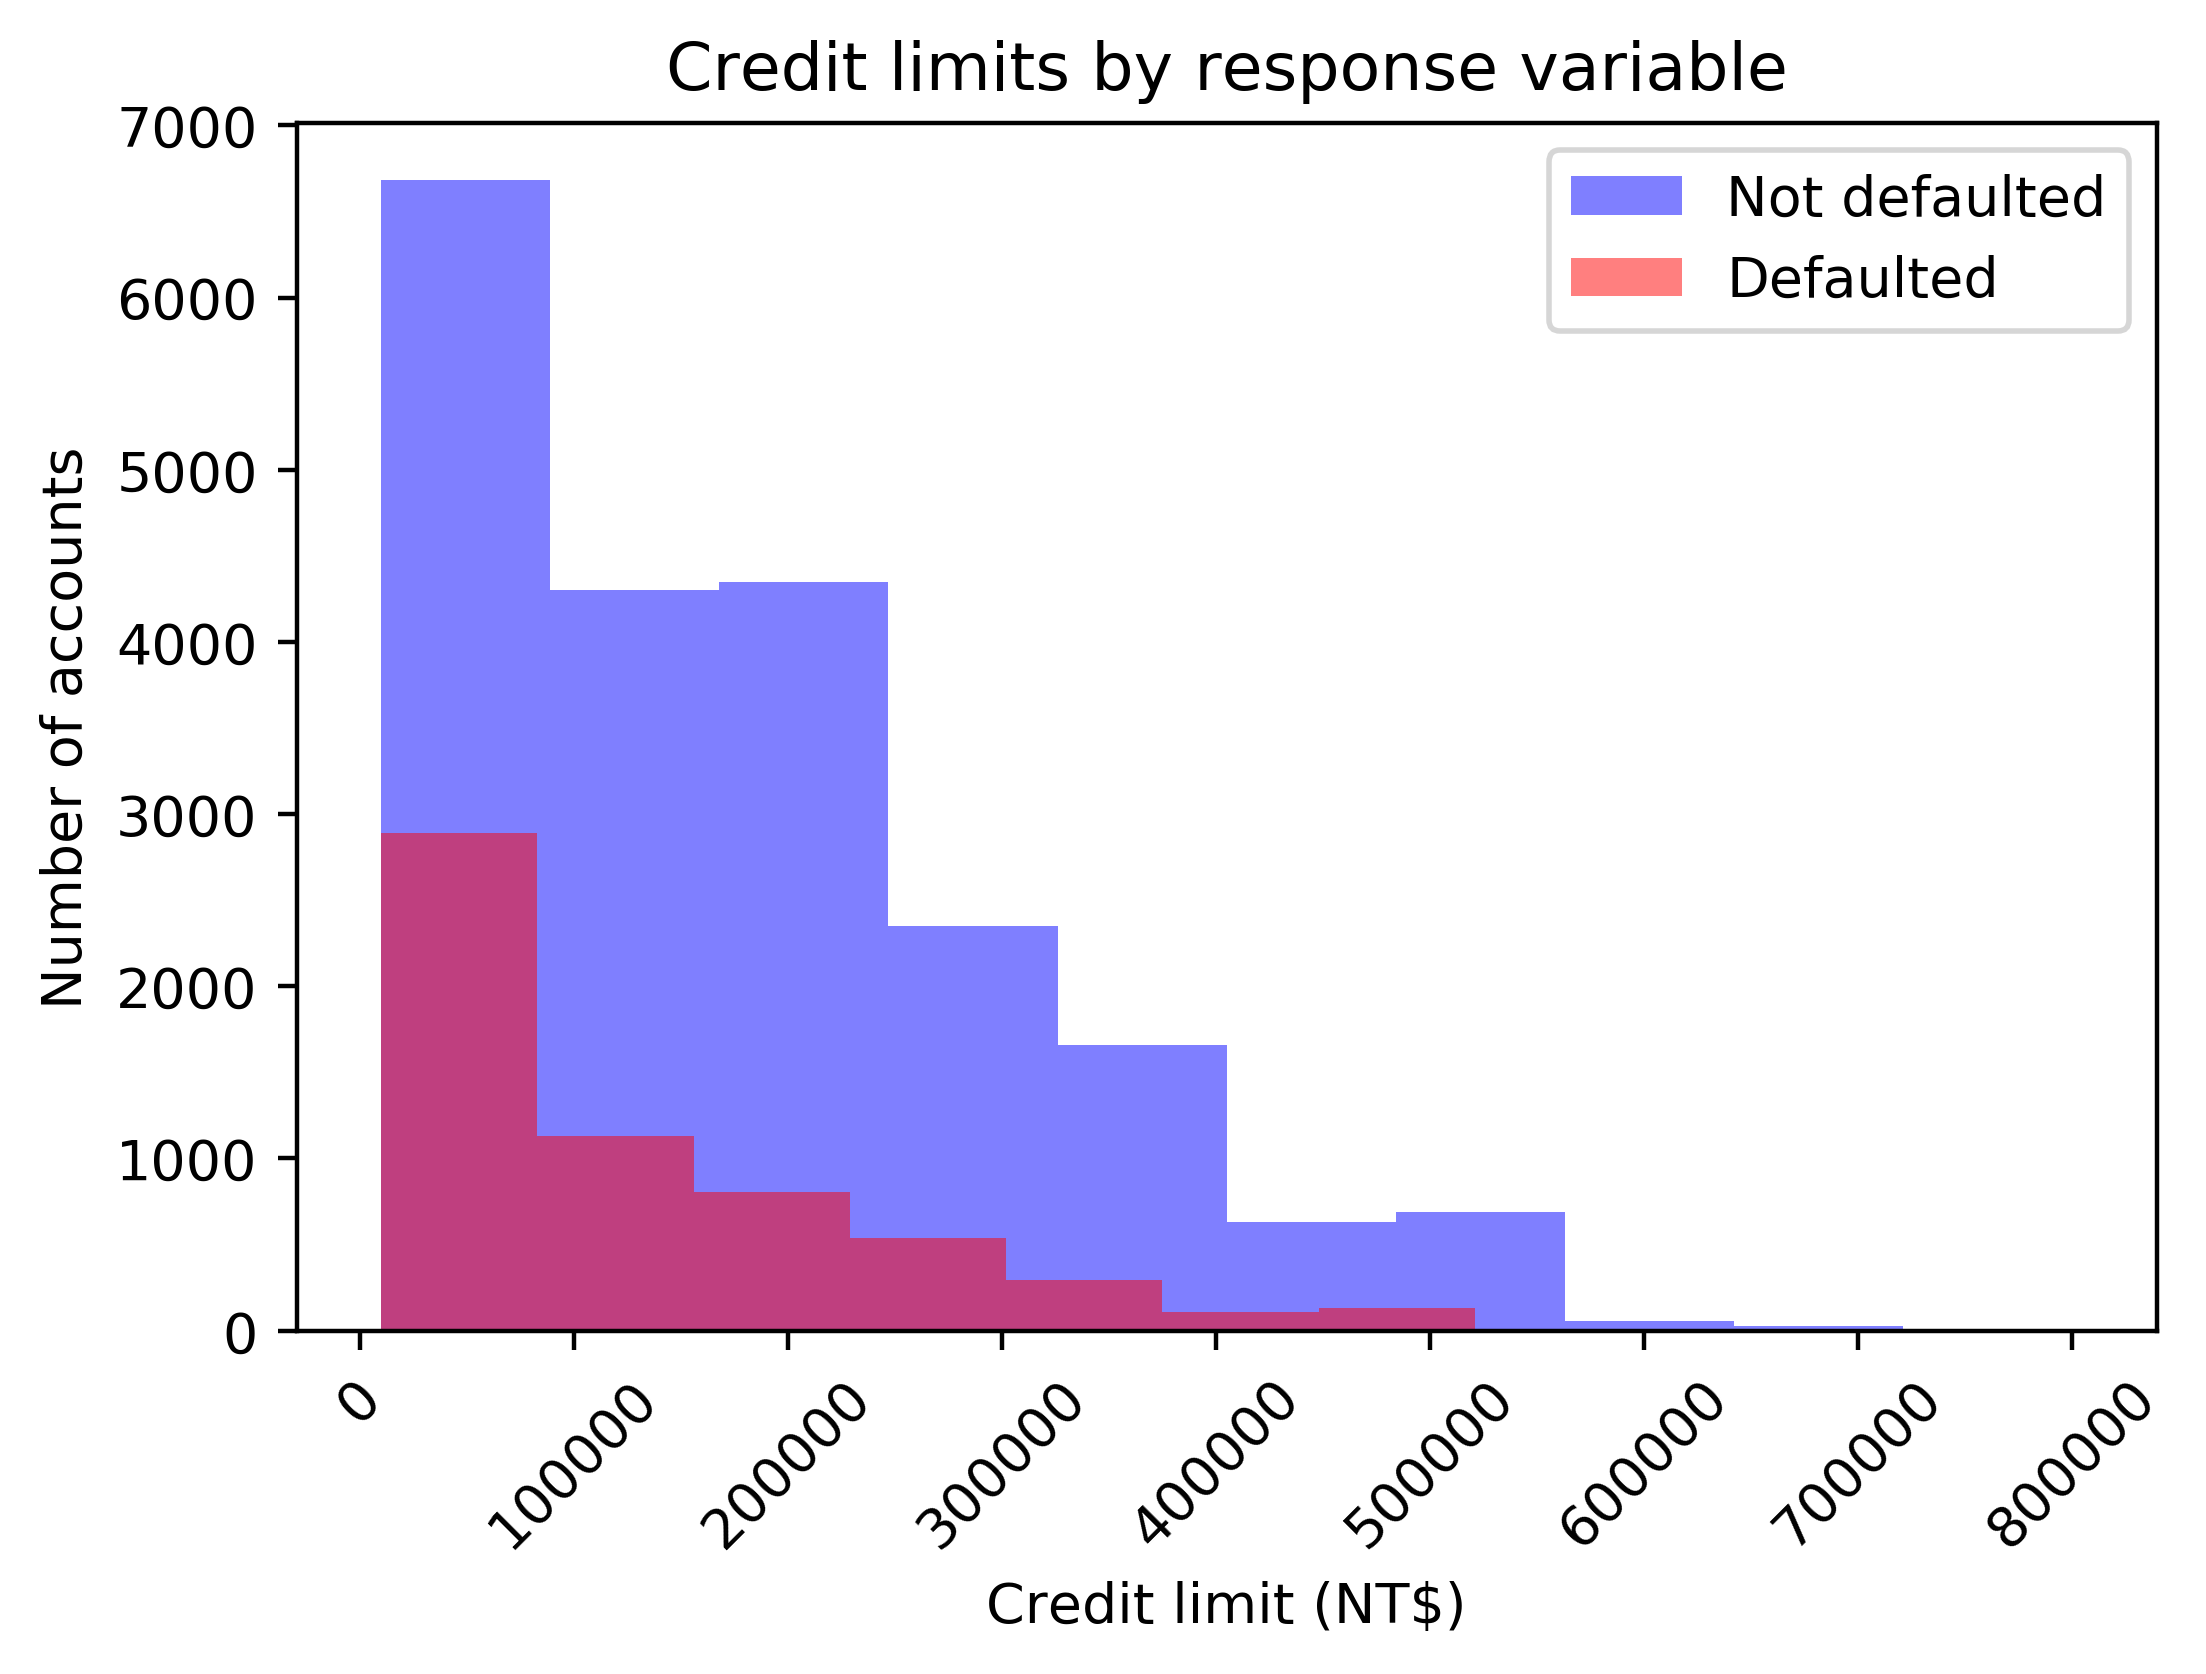

In [20]:
axes = plt.axes()
axes.hist(df.loc[neg_mask, 'LIMIT_BAL'], alpha=0.5, color='blue')
axes.hist(df.loc[pos_mask, 'LIMIT_BAL'], alpha=0.5, color='red')
axes.tick_params(axis='x', labelrotation=45)
axes.set_xlabel('Credit limit (NT$)')
axes.set_ylabel('Number of accounts')
axes.legend(['Not defaulted', 'Defaulted'])
axes.set_title('Credit limits by response variable')

<p>This plot is clear, but not as interpretable as the one before. The primary visual takeaway here is that hte blue histogram is bigger than the red one. This is due to the fact that fewer accounts default, than don't default.</p>

#### If we want to show how the shapes of these histograms are different and not just their sizes, we an make the total plotted area the same by <em>normalizing</em> them. Matplotlib provides a keyword argument that makes this easy, creating what might be considered an empirical version of a <em>probability mass function</em>.

#### This means that the integral, or the area contained within each histogram, will be equal to 1 after normalization, since probabilities sum to 1.

In [21]:
bin_edges = list(range(0,850000,50000))
print(bin_edges[-1])

800000


Text(0.5, 1.0, 'Normalized distributions of credit limits by response variable')

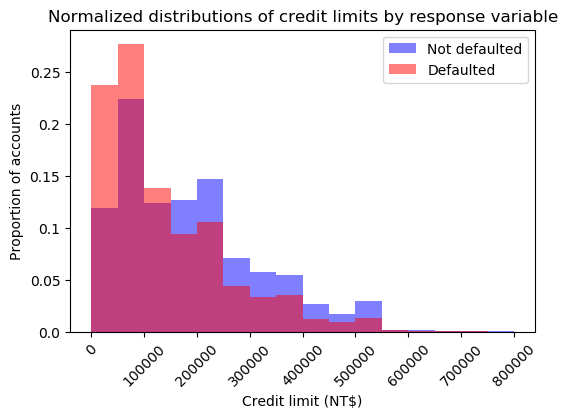

In [22]:
mpl.rcParams['figure.dpi'] = 100 
axes = plt.axes()

# The density=True is what normalizes the histograms
axes.hist(df.loc[neg_mask, 'LIMIT_BAL'], bins=bin_edges, alpha=0.5, density=True, color='blue')
axes.hist(df.loc[pos_mask, 'LIMIT_BAL'], bins=bin_edges, alpha=0.5, density=True, color='red')

axes.tick_params(axis='x', labelrotation=45)
axes.set_xlabel('Credit limit (NT$)')
axes.set_ylabel('Proportion of accounts')

y_ticks = axes.get_yticks()
axes.set_yticklabels(np.round(y_ticks*50000,2))
axes.legend(['Not defaulted', 'Defaulted'])
axes.set_title('Normalized distributions of credit limits by response variable')

<h2>Feature Engineering</h2>

<p>There are drawbacks to univariate feature selection. In particular, it does not consider the <strong>interactions</strong> between features. Also, with methods used here until now, only the linear effects of features are captured</p>

<p>If a feature is more predictive when it has undergone some type of <strong>transformation</strong>, such as <strong>polynomial</strong> or <strong>logarithmic</strong> transformations, or <strong>binning (discretization)</strong>, linear techniques of univariate feature selection may not be effective.</p>

<p>The shortcomings of linear feature selection models can be remedied by non-linear modeling techniques such as <strong>Random Forest</strong></p>

<p>That said, there is still value in looking for simple relationships that can be found by linear methods for univariate feature selection, and it is quick to do.</p>

## Understanding Logistic Regression with `function` Syntax in Python and the Sigmoid Function

<p>The <strong>Sigmoid Function</strong> used in <strong>Logistic Regression</strong> invovles the <strong>irrational number e</strong>, which is also known as the base of the <strong>natural logarithm</strong>, in contrast to the base-10 lograithms we used earlier for data exploration.</p>

In [23]:
# NumPy e^x
x = 0
print(np.exp(x))
x=1
print(np.exp(x))

1.0
2.718281828459045


<p>Since <code>np.exp</code> is vectorized, it will compute the exponential of the whole array at once, in an efficient manner.</p>

In [24]:
X_exp = np.linspace(-4, 4, 81)
Y_exp = np.exp(X_exp)

# Exercise 13: Plotting the Sigmoid Function

Text(0.5, 1.0, 'Plot of $e^X$')

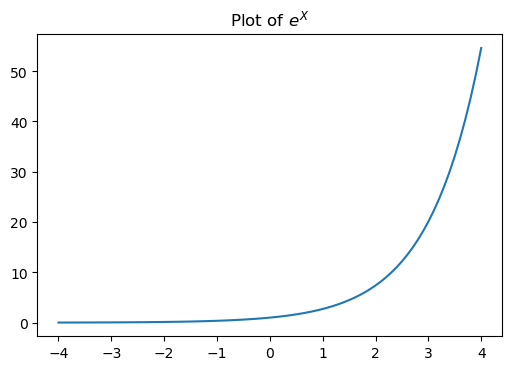

In [25]:
plt.plot(X_exp, Y_exp)

# Using LaTex for mathematical notation in the title
plt.title('Plot of $e^X$')

<h3>Considerations about the sigmoid in terms of the exponential</h3>

<p>The sigmoid involves $e^{-x}$, as opposed to $e^X$.</p>

<p>The graph of $e^{-x}$ is just the reflection of $e^X$ about the <em>y-axis</em>.</p>

Text(0.5, 1.0, 'Plot of $e^{-X}$')

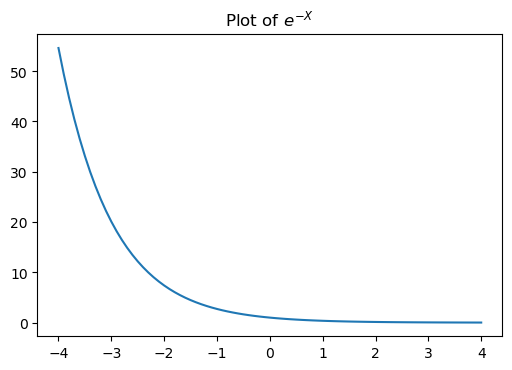

In [26]:
Y_exp = np.exp(-X_exp)
plt.plot(X_exp, Y_exp)
plt.title('Plot of $e^{-X}$')

#### Define the sigmoid function:

In [27]:
def sigmoid(X):
    Y = 1 / (1 + np.exp(-X))
    return Y

#### Make a larger range of x-values to plot over and plot the sigmoid:

Text(0.5, 1.0, 'The sigmoid function')

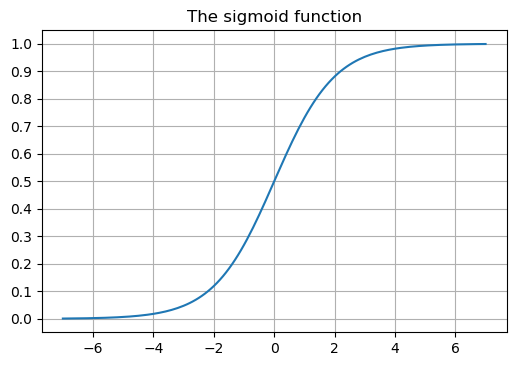

In [28]:
X_sig = np.linspace(-7,7,141)
Y_sig = sigmoid(X_sig)
plt.plot(X_sig,Y_sig)
plt.yticks(np.linspace(0,1,11))
plt.grid()
plt.title('The sigmoid function')

<h3>What is special about the sigmoid function</h3>

<p>The output of this function is strictly bound between 0 and 1. This is a good property for a function that should predict probabilities, which are also required to fall within that range.Technically, probabilities can be exactly equal to 0 or 1, while the sigmoid never is. But the sigmoid can be close enough that this is not a practical limitation</p>

<h3>Sigmoid curves in scientific applications</h3>

<p>In biology, they can be used to describe the growth of an organism, that starts slowly and then has a rapid phase followed by a smooth tapering off as the final size is reached. Sigmoid can also be used to describe population growth, which has a similar trajectory, increasing rapidly but then slowing as the carrying capacity of the environment is reached.</p>

## Note 
#### Logistic Regression is considered a LINEAR MODEL. A model is considered linear if the transformation of features that is used to calculate the prediction is a linear combination of the features. 

#### The possibilities for a linear combination are that each feature can be multiplied by a numerical constant, these terms can be added together, and an additional constant can be added

## Exercise 14: Examining the Appropriateness of Features for Logistic Regression

In [29]:
group_by_pay_mean_y

,default payment next month
PAY_1,
-2,0.131664
-1,0.170002
0,0.128295
1,0.336400
2,0.694701
3,0.773973
4,0.682540
5,0.434783
6,0.545455


#### Extract the mean values of the response variable from these groups and put them in a variable <code>p</code> representing the probability of default.
#### Create a probability <code>q</code> of not defaulting. Since there are only two possible outcomes in this binary problem, and the probabilities of all outcomes add up to 1, it is easy to calculate q.

In [30]:
p = group_by_pay_mean_y['default payment next month'].values
q = 1-p
print(p)
print(q)

[0.13166397 0.17000198 0.12829525 0.33639988 0.69470143 0.7739726
 0.68253968 0.43478261 0.54545455 0.77777778 0.58823529]
[0.86833603 0.82999802 0.87170475 0.66360012 0.30529857 0.2260274
 0.31746032 0.56521739 0.45454545 0.22222222 0.41176471]


#### Calculate the odds ration from <code>p</code> to <code>q</code>, as well as the log odds, using the natural logarithm function from NumPy.

In [31]:
odds_ratio = p/q
print(odds_ratio)
log_odds = np.log(odds_ratio)
print(log_odds)

[0.15162791 0.20482215 0.14717742 0.50693161 2.27548209 3.42424242
 2.15       0.76923077 1.2        3.5        1.42857143]
[-1.88632574 -1.58561322 -1.91611649 -0.67937918  0.82219194  1.23088026
  0.76546784 -0.26236426  0.18232156  1.25276297  0.35667494]


#### In order to plot the log odds against the values of the feature, we can get the feature values from the index  of the DataFrame containing the groupby/mean.

In [32]:
group_by_pay_mean_y.index

Int64Index([-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8], dtype='int64', name='PAY_1')

Text(0.5, 0, 'Values of PAY_1')

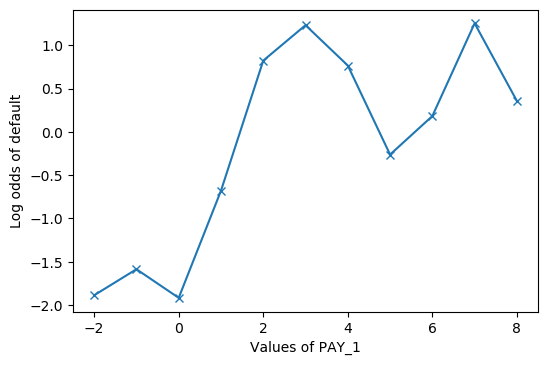

In [33]:
plt.plot(group_by_pay_mean_y.index, log_odds, '-x')
plt.ylabel('Log odds of default')
plt.xlabel('Values of PAY_1')

<p>We can see in this plot that the relationship between the log odds of the response variable and the <strong>PAY_1</strong> feature is not all that different from the relationship of the rate of default and this feature that we plotted before (<em>Visualizing the Relationship Between Features and Response</em>).

# From Logistic Regression Coefficients to Predictions Using the Sigmoid

<p>Recal that logistic regression predicts the probability of class membership, according to the sigmoid equation.</p>

<p>When you call the <code>.fit</code> method on a logistic regression model object in scikit-learn using the training data, the parameters are estimated from this labeled training data.</p>

<p>When yo call <code>predict</code>, scikit-learn calculates predicted probabilities according to the fitted parameter values and the sigmoid equation. A given sample will then be classified as <strong>positive if <em>p >= 0.5</em></strong>, and <strong>negative otherwise</strong>.</p>

Text(0, 0.5, '$p$')

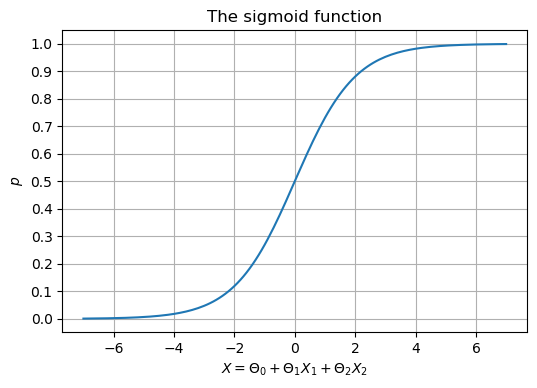

In [34]:
X_sig = np.linspace(-7,7,141)
Y_sig = sigmoid(X_sig)
plt.plot(X_sig,Y_sig)
plt.yticks(np.linspace(0,1,11))
plt.grid()
plt.title('The sigmoid function')
plt.xlabel('$X = \Theta_0 + \Theta_1 X_1 + \Theta_2 X_2$')
plt.ylabel('$p$')

# Exercise 15: Linear Decision Boundary of Logistic Regression

#### Generate the features with synthetic data.

In [35]:
np.random.seed(seed=6)

X_1_pos = np.random.uniform(low=1, high=7, size=(20,1))

X_1_neg = np.random.uniform(low=3, high=10, size=(20,1))

X_2_pos = np.random.uniform(low=1, high=7, size=(20,1))

X_2_neg = np.random.uniform(low=3, high=10, size=(20,1))

<p>We have 20 sampples each in the positive and negative classes, for a total of 40 samples, and we have two features for each sample.</p>

#### Plot these data [with a scatter plot], coloring the positive samples in red and the negative samples in blue.

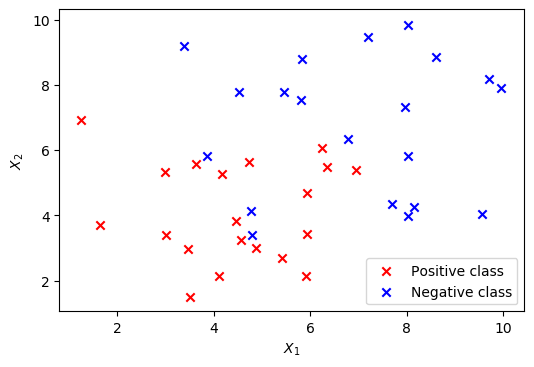

In [36]:
plt.scatter(X_1_pos, X_2_pos, color='red', marker='x')
plt.scatter(X_1_neg, X_2_neg, color='blue', marker='x')
plt.xlabel('$X_1$')
plt.ylabel('$X_2$')
plt.legend(['Positive class', 'Negative class'])

#### In order to use our synthetic data with scikit-learn, we need to assemble them into a matrix.

#### We use NumPy's <code>block</code> function for this to create a 40x2 matrix.

In [37]:
X = np.block([[X_1_pos, X_2_pos], [X_1_neg, X_2_neg]])
print(X.shape)
print(X[0:3])

(40, 2)
[[6.35716091 5.4790643 ]
 [2.99187883 5.3444234 ]
 [5.92737474 3.43664678]]


#### Create a vertical stack (NumPy <code>vstack</code>) of 20 1s and 20 0s to match our arrangement of the features and reshape to the way that scikit-learn expects.

In [38]:
y = np.vstack((np.ones((20,1)), np.zeros((20,1)))).reshape(40,)
print(y[0:5])
print(y[-5:])

[1. 1. 1. 1. 1.]
[0. 0. 0. 0. 0.]


#### We are ready to fit a logistic regression to these data, using all of it as training data and examining how well a linear model is able to fit it.

In [39]:
from sklearn.linear_model import LogisticRegression

example_lr = LogisticRegression(solver='liblinear')

example_lr

example_lr.fit(X, y)

y_pred = example_lr.predict(X)

#### Get predictions and separate them into indices of positive and negative class predictions.

In [40]:
positive_indices = [counter for counter in range(len(y_pred)) if y_pred[counter]==1]
negative_indices = [counter for counter in range(len(y_pred)) if y_pred[counter]==0]

print(positive_indices)
print(negative_indices)

[1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 16, 17, 32, 38]
[0, 9, 15, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35, 36, 37, 39]


#### Plot: in the form of circles around each data point, colored according to the prediction.

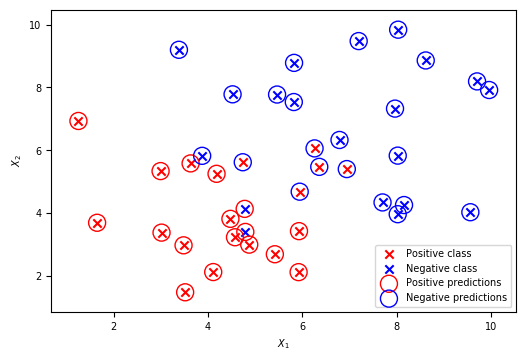

In [41]:
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['font.size'] = 7

plt.scatter(X_1_pos, X_2_pos, color='red', marker='x')
plt.scatter(X_1_neg, X_2_neg, color='blue', marker='x')

plt.scatter(X[positive_indices,0], X[positive_indices,1], s=150, marker='o',
            edgecolors='red', facecolors='none')
plt.scatter(X[negative_indices,0], X[negative_indices,1], s=150, marker='o',
            edgecolors='blue', facecolors='none')

plt.xlabel('$X_1$')
plt.ylabel('$X_2$')
plt.legend(['Positive class', 'Negative class', 'Positive predictions', 'Negative predictions'])

<p>$\theta_0 + \theta_1 X_1 + \theta_2 X_2 = 0$ is the equation for the decision boundary line, for a threshold of 0.5. Solving for "$y = mx + b$" form,</p>

$X_2 = -\frac{\theta_1}{\theta_2}X_1 - \frac{\theta_0}{\theta_2}$

<p>From the plot, it is apparent that the classifier struggles with data points that are close to where you may imagine the linear decision boundary to be. Some of these may end up on the wrong side of that boundary.</p>

#### Get the coefficients from the fitted model and print them.

In [42]:
theta_1 = example_lr.coef_[0][0]
theta_2 = example_lr.coef_[0][1]
print(theta_1, theta_2)

-0.20245058016285844 -0.25336423626773213


#### Get the intercept and print it.

In [43]:
theta_0 = example_lr.intercept_
print(theta_0)

[2.25479161]


#### Use the coefficients and intercept to define the linear decision boundary.

In [44]:
X_1_decision_boundary = np.array([0, 10])

X_2_decision_boundary = -(theta_1/theta_2)*X_1_decision_boundary - (theta_0/theta_2)

#### Plot the decision boundary

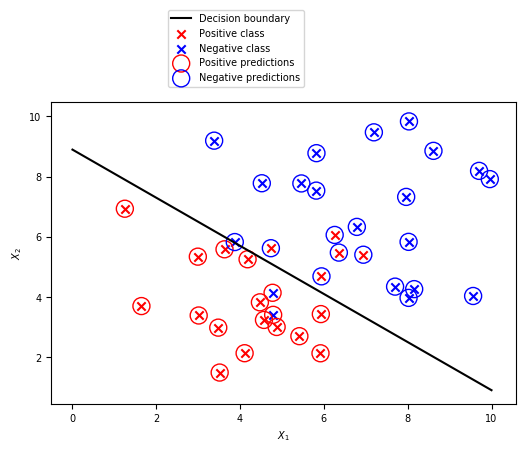

In [45]:
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['font.size'] = 7

pos_true = plt.scatter(X_1_pos, X_2_pos, color='red', marker='x', label='Positive class')
neg_true = plt.scatter(X_1_neg, X_2_neg, color='blue', marker='x', label='Negative class')
pos_pred = plt.scatter(X[positive_indices,0], X[positive_indices,1], s=150, marker='o',
            edgecolors='red', facecolors='none', label='Positive predictions')
neg_pred = plt.scatter(X[negative_indices,0], X[negative_indices,1], s=150, marker='o',
            edgecolors='blue', facecolors='none', label='Negative predictions')
dec = plt.plot(X_1_decision_boundary, X_2_decision_boundary, 'k-', label='Decision boundary')
plt.xlabel('$X_1$')
plt.ylabel('$X_2$')
plt.legend(loc=[0.25, 1.05])

<p>In general, the decision boundary can be described by a <strong>hyperplane</strong>, which is the generalization of a straight to multi-dimensional spaces. However, the restrictive nature of the linear decision boundary is still a factor to consider.</p>

# Activity 3: Fitting a Logistic Regression Model and Directly Using the Coefficients

In [46]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
df[['PAY_1', 'LIMIT_BAL']].values, df['default payment next month'].values,
test_size=0.2, random_state=24)

print(X_train.shape)
print(X_test.shape)

(21331, 2)
(5333, 2)


In [47]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(solver='liblinear')

lr_model.fit(X_train, y_train)

y_pred = lr_model.predict(X_test)

y_pred_proba = lr_model.predict_proba(X_test)

print(lr_model.coef_, lr_model.intercept_)

[[ 8.27451187e-11 -6.80876727e-06]] [-6.57647457e-11]
